Parameter setting

In [6]:
targetGroup = 1        # 1, 2, or 3 for specifying 1st, 2nd, and 3rd groups
dropoutRatio = 0.0
dataSet = "CIFAR10"     # "CIFAR10", "SVHN", or "TinyImageNet"
modelDir = "models/"

modelDir = modelDir if modelDir.endswith("/") else modelDir + "/"
modelName = modelDir + dataSet + "dropoutRatio" + str(dropoutRatio) +".h5"

In [7]:
if (targetGroup == 1 or targetGroup == 2) and (dataSet != "CIFAR10" and dataSet != "SVHN") :
  print( "un-supported : " + dataSet + ", group" + str(targetGroup))
  sys.exit(-1)
elif targetGroup == 3 and dataSet != "TinyImageNet":
  print( "un-supported : " + dataSet + ", group" + str(targetGroup))
  sys.exit(-1)

In [32]:
# for colaboratory user

#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive/My\ Drive/

In [9]:
if targetGroup == 1:
  startLayer = 11
elif targetGroup == 2:
  startLayer = 4
elif targetGroup == 3:
  startLayer = 3
else:
  sys.exit(-1)

In [10]:
import numpy as np
import itertools
import os
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, lil_matrix, identity
import sys,math
from scipy.io import mmwrite, mmread

Load Model

In [11]:
from keras.models import load_model
import keras
model = load_model( modelName )

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        3

Set Target Layers

In [13]:
targetLayer = [] 
for i in range(startLayer, len(model.layers)):
  l = model.get_layer(index=i)
  if isinstance(l, keras.layers.Conv2D) or isinstance(l, keras.layers.MaxPooling2D) \
    or isinstance(l, keras.layers.AveragePooling2D) or isinstance(l, keras.layers.Dense):
    targetLayer.append(l)
    if( len(targetLayer) == 2 ):
      break
  elif isinstance(l, keras.layers.Flatten) or isinstance(l, keras.layers.Dropout):
    pass
  else:
    print ("un-supported layer: " + str(l))
    sys.exit(-1)

make relevance matrix for target layers

In [14]:
def setRelevancePooling2D( relevance, startPosition, layer ):
  (temp, input_height, input_width, input_depth ) = layer.input_shape
  (temp, output_height, output_width, output_depth ) = layer.output_shape

  if layer.pool_size[0] == layer.pool_size[1]:
    f = layer.pool_size[0]
  else:
    sys.exit(-1)
  s = layer.strides[0]
  if layer.padding == "valid":
    p = 0
  elif layer.padding == "same":
    p = math.ceil((layer.pool_size[0]-1)/2)
  else:
    sys.exit(-1)
  print("stride: " + str(s) + ", padding: "+ str(p))

  #number of neuron from output layer
  startRowNumber = startPosition + output_height * output_width * output_depth
  weight = 1 / (f * f)
  print("input: "+ str(input_height)+ ", " + str(input_width) + ", " + str(input_depth) + ", " +str(input_height*input_width*input_depth))
  print("output: " + str(output_height)+ ", " + str(output_width) + ", " + str(output_depth) +", " + str(output_height*output_width*output_depth))

  for z in range(0, output_depth):
    Z = z
    for y in range(0, output_width):
      for x in range(0, output_height):
        for Y in range( y * s - p, y * s - p + f):
          for X in range( x * s - p, x * s - p + f):
            if (X >= 0 and Y >= 0 and X < input_height and Y < input_width) :
              relevance[ startRowNumber + X + Y * input_height + Z * input_height * input_width, \
                        startPosition + x + y * output_height + z * output_height * output_width] = weight

In [15]:
def setRelevanceConv2D( relevance, startPosition, layer ):
  (temp, input_height, input_width, input_depth ) = layer.input_shape
  (temp, output_height, output_width, output_depth ) = layer.output_shape

  if layer.kernel_size[0] == layer.kernel_size[1]:
    f = layer.kernel_size[0]
  else:
    sys.exit(-1)
  s = layer.strides[0]
  if layer.padding == "valid":
    p = 0
  elif layer.padding == "same":
    p = math.ceil((layer.kernel_size[0]-1)/2)
  else:
    sys.exit(-1)
  print("stride: " + str(s) + ", padding: "+ str(p))

  #number of neuron from output layer
  startRowNumber = startPosition + output_height * output_width * output_depth
  for z in range(0, output_depth):
    weight, bias = layer.get_weights()
    filter = weight[:,:,:,z]
    filterPlus = filter * ( filter > 0)
    normalizeFactor = np.sum( filterPlus )

    for y in range(0, output_width):
      for x in range(0, output_height):
        for Y in range( y * s - p, y * s - p + f):
          for X in range( x * s - p, x * s - p + f):
            for Z in range( 0, input_depth):
              if (X >= 0 and Y >= 0 and X < input_height and Y < input_width) :
                relevance[ startRowNumber + X + Y * input_height + Z * input_height * input_width, \
                        startPosition + x + y * output_height + z * output_height * output_width] = filterPlus[ X - x * s + p, Y - y * s + p, Z ]/normalizeFactor

In [16]:
def updateRelevanceDense( relevance, startPosition, l ):
  weight, bias = l.get_weights()
  inputNeuron = weight.shape[0]
  outputNeuron = weight.shape[1]
  startRowPosition = startPosition + l.output_shape[1]
  weightPlus = weight * ( weight > 0)
  for j in range( 0, outputNeuron ):
    normalizeFactor = 0
    for i in range( 0, inputNeuron):
      normalizeFactor += weightPlus[i][j]
    for i in range( 0, inputNeuron ):
      relevance[ startRowPosition + i, startRowPosition - outputNeuron + j ] = weightPlus[i][j] / normalizeFactor

In [17]:
def getInputOutput( l ):
  input = 0
  output = 0
  if isinstance(l, keras.layers.Conv2D) or isinstance(l, keras.layers.MaxPooling2D) or isinstance(l, keras.layers.AveragePooling2D):
    input = l.input_shape[1]  * l.input_shape[2] * l.input_shape[3]
    output = l.output_shape[1]  * l.output_shape[2] * l.output_shape[3]
  elif isinstance(l, keras.layers.Dense):
    input = l.input_shape[1]
    output = l.output_shape[1]
  else:
    sys.exit(-1)
  return input, output

In [18]:
def makeRelevanceMatrix( model, startLayer ):
  # get network size
  print("matrix size :" + str(sum(targetNeuron)) + "x" +str(sum(targetNeuron)) + ", " + str(targetNeuron))
  relevance = lil_matrix( identity( np.sum( targetNeuron ) ) )

  #startPosition means the number of
  startPosition = 0

  for l in reversed ( targetLayer ):
    print(l)
    if isinstance(l, keras.layers.Dense ):
      updateRelevanceDense( relevance, startPosition, l )
      startPosition += l.output_shape[1]
      print("startPosition "+str(startPosition))
    elif isinstance(l, keras.layers.Flatten ) or isinstance(l, keras.layers.Dropout):
      #do nothing
      pass
    elif isinstance(l, keras.layers.MaxPooling2D) or isinstance(l, keras.layers.AveragePooling2D):
      setRelevancePooling2D( relevance, startPosition, l)
      startPosition += l.output_shape[1] * l.output_shape[2] * l.output_shape[3]
      print("startPosition "+str(startPosition))
    elif isinstance(l, keras.layers.Conv2D):
      setRelevanceConv2D( relevance, startPosition, l)
      startPosition += l.output_shape[1] * l.output_shape[2] * l.output_shape[3]
      print("startPosition "+str(startPosition))
    else:
      print ( "un-supported layer types : " + str(l) + "\n")
      sys.exit(-1)

  return relevance

In [19]:
#select targetLayer
targetLayer = [] 
for i in range(startLayer, len(model.layers)):
  l = model.get_layer(index=i)
  if isinstance(l, keras.layers.Conv2D) or isinstance(l, keras.layers.MaxPooling2D) \
    or isinstance(l, keras.layers.AveragePooling2D) or isinstance(l,keras.layers.Dense):
    targetLayer.append(l)
    if( len(targetLayer) == 2 ):
      break
  elif isinstance(l, keras.layers.Flatten) or isinstance(l, keras.layers.Dropout):
    pass

targetNeuron = []
input, output = getInputOutput(targetLayer[0])
targetNeuron = [input, output]
input, output = getInputOutput(targetLayer[1])
targetNeuron.append(output)

In [20]:
relevance = makeRelevanceMatrix( model, targetLayer )

matrix size :1034x1034, [512, 512, 10]
startPosition 10
startPosition 522


Set input neurons of sub-graph

In [21]:
#set input neuron of sub-graph
inputNeuron = []
if targetGroup == 1:
  inputNeuron = range( sum(targetNeuron[1:]), sum(targetNeuron))
elif targetGroup == 2:
  for z in range(0,32):
    for y in range(7, 10):
      for x in range(7, 10):
        inputNeuron.append( x + y * 15 + z * 15 * 15 + sum(targetNeuron[1:]))
elif targetGroup == 3:
  inputNeuron = range( sum(targetNeuron[1:]), sum(targetNeuron[1:]) + 512 )
else:
  sys.exit(-1)


Set Filtration

In [22]:
#filtration
r = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2,
     1.0e-1, 0.9e-1, 0.8e-1, 0.7e-1, 0.6e-1, 0.5e-1, 0.4e-1, 0.3e-1, 0.2e-1, 
     1.0e-2, 0.9e-2, 0.8e-2, 0.7e-2, 0.6e-2, 0.5e-2, 0.4e-2, 0.3e-2, 0.2e-2,
     1.0e-3, 0.9e-3, 0.8e-3, 0.7e-3, 0.6e-3, 0.5e-3, 0.4e-3, 0.3e-3, 0.2e-3,
     1.0e-4, 0.9e-4, 0.8e-4, 0.7e-4, 0.6e-4, 0.5e-4, 0.4e-4, 0.3e-4, 0.2e-4,
     1.0e-5, 0.9e-5, 0.8e-5, 0.7e-5, 0.6e-5, 0.5e-5, 0.4e-5, 0.3e-5, 0.2e-5,
     1.0e-6, 0.9e-6, 0.8e-6, 0.7e-6, 0.6e-6, 0.5e-6, 0.4e-6, 0.3e-6, 0.2e-6,
     1.0e-7]

setSimplex

In [23]:
def setSimplex( simplexSet, path, rel):    
    if len(np.where( rel >= np.array(r))[0]) == 0:
        pass
    else:
        minNum = min ( np.where( rel >= np.array(r))[0])    
        simplexSet[ minNum + 1 ].add( tuple( path ))
    

idfySimplex

In [24]:
relevance = relevance.tolil() 
csr_relevance = csr_matrix(relevance)
csc_relevance = csc_matrix(relevance)

simplexSet = [set() for i in range(0, len(r) + 1)]
#set 0-simplex
for i in range(0, sum(targetNeuron)):
    simplexSet[1].add( tuple([i]) )

for start in inputNeuron: 
    if( start % 10 == 0):
        print( str(start)+ ", ", end = "")
        
    for end in np.nonzero(relevance[start,:])[1] :
        if start != end:
            setSimplex( simplexSet, [start,end], relevance[start,end] )
            for endend in np.nonzero( relevance[end,:])[1]:
                if end != endend :
                    setSimplex( simplexSet, [end,endend], relevance[end,endend])
    
    startRow = csr_relevance.getrow( start )
    #loop for 1st Layer
    for end in range( sum(targetNeuron[3:]), sum(targetNeuron[2:]) ):
        endColumn = csc_relevance.getcol( end )
        multi = startRow.multiply( endColumn.transpose() )
        for ind in multi.indices:
            path = [start, ind, end]
            rel = multi[0, ind]
            setSimplex( simplexSet, path, rel )
            path = [start , end]
            setSimplex( simplexSet, path, rel )


530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 

draw PH diagram

In [25]:
!pip install dionysus

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Created wheel for dionysus: filename=dionysus-2.0.8-cp37-cp37m-linux_x86_64.whl size=322708 sha256=b3c404db41b4565190a793e50b0f731ec345133d6153efdcbb9b0119a3738b16
  Stored in directory: /root/.cache/pip/wheels/2b/bb/90/2e8a30f3af9a13951d8c76fa73689f6b8d87234c603bbd7003
Successfully built dionysus


In [26]:
import dionysus as d
f = d.Filtration()

In [27]:
# register simplex to dionysus
for i in range(1, len(r) + 1 ):
    print(str(i) + ", ", end = "")
    for j in range(1, i+1):
        for e in simplexSet[j]:
            f.add( d.Simplex( e, i ))

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 

In [28]:
f.sort()

In [29]:
m = d.homology_persistence(f, prime=2)

In [30]:
dgms = d.init_diagrams(m, f)

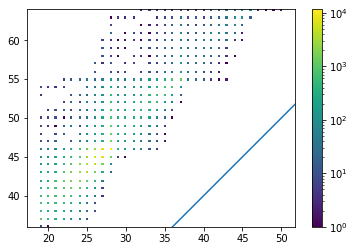

In [31]:
d.plot.plot_diagram_density( dgms[1], show=True, diagonal=True )